In [1]:
# Init
import glob
import os
import pickle
import sys

module_path = os.path.abspath(os.path.join("../src/simulicronalpha/"))
if module_path not in sys.path:
    sys.path.append(module_path)

import multiprocessing
import warnings

# Imports
import numpy as np
import pandas as pd

np.set_printoptions(suppress=True)
# For loading data
import concurrent.futures
import gc
import json
import random

# Plotting imports
import altair as alt
from numpy import concatenate as c
from numpy import cumsum

alt.data_transformers.disable_max_rows()
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [2]:
# Acc. functions
def returnLast(lst):
    return lst[-1]


def returnGen(lst):
    return lst[3000]


def returnMax(series):
    return max(series)


def returnList(HGTGen, lst):
    return lst[HGTGen]


def colorRanges(i):
    if i == 0:
        return "0"
    elif i > 0 and i <= 50:
        return "1-50"
    elif i > 50 and i <= 100:
        return "50-100"
    elif i > 100 and i <= 200:
        return "100-200"
    elif i > 200 and i <= 300:
        return "200-300"
    elif i > 300:
        return ">300"


def zeroDivision(n, d):
    return n / d if d else maxVal


def dfWrangler(dataFrame):
    # Perform some data wrangling
    dataFrame[["TranspositionRate_1", "TranspositionRate_2"]] = pd.DataFrame(
        dataFrame.TRate.tolist(), index=dataFrame.index
    )
    dataFrame[["TE_1_CN", "TE_2_CN"]] = dataFrame["TEfamilyCN"].apply(pd.Series)
    dataFrame[["TE_1_RG", "TE_2_RG"]] = dataFrame["TEfamilyRg"].apply(pd.Series)
    dataFrame[["TE_1_pi", "TE_2_pi"]] = dataFrame["TEpi"].apply(pd.Series)

    # Add column for the last acn (average copy number) for each transposon family
    dataFrame["TE_1_ACN"] = dataFrame["TE_1_CN"].apply(lambda x: returnLast(x))
    dataFrame["TE_2_ACN"] = dataFrame["TE_2_CN"].apply(lambda x: returnLast(x))

    # Add column for copies not present in clusters
    dataFrame["TE_1_NCN"] = dataFrame["TE_1_ACN"] - dataFrame["TE_1_pi"]
    dataFrame["TE_2_NCN"] = dataFrame["TE_2_ACN"] - dataFrame["TE_2_pi"]
    dataFrame["TE_1_NCN_l"] = np.log(dataFrame["TE_1_ACN"] - dataFrame["TE_1_pi"])
    dataFrame["TE_2_NCN_l"] = np.log(dataFrame["TE_2_ACN"] - dataFrame["TE_2_pi"])

    # Add column for nth generation copy number
    dataFrame["TE_1_ACN_N"] = dataFrame["TE_1_CN"].apply(lambda x: returnGen(x))
    dataFrame["TE_2_ACN_N"] = dataFrame["TE_2_CN"].apply(lambda x: returnGen(x))

    # Get ranges for adding colors later
    dataFrame["TE_1_NCN_R"] = dataFrame["TE_1_NCN"].apply(lambda x: colorRanges(x))
    dataFrame["TE_2_NCN_R"] = dataFrame["TE_2_NCN"].apply(lambda x: colorRanges(x))

    # Add column for copy number ratio
    dataFrame["(α/β) copy number"] = dataFrame["TE_1_NCN"] / dataFrame["TE_2_NCN"]
    dataFrame["log(α/β) copy number"] = np.log(dataFrame["(α/β) copy number"])

    # Add column for max alpha and beta
    dataFrame["Max α"] = dataFrame["TE_1_CN"].apply(lambda x: returnMax(x))
    dataFrame["Max β"] = dataFrame["TE_2_CN"].apply(lambda x: returnMax(x))
    dataFrame["Max α/β"] = np.log(dataFrame["Max α"] / dataFrame["Max β"])

    return dataFrame


def dfReader(resultDir, suffix):
    # Read the json files into pandas dataframe
    SimulationRecords = []
    for filename in glob.glob(os.path.join(resultDir, suffix)):
        with open(filename, "r") as file:
            SimulationRecords.append(json.load(file))

    SimulationResultsDataFrame = pd.DataFrame(SimulationRecords)

    # Create a copy for inplace handling
    resultDataframe = SimulationResultsDataFrame.copy(deep=True)
    resultDataframe = dfWrangler(resultDataframe)
    return resultDataframe


# Since pickle format is not working as intended.
# Insert angry thoughts abouts pickle format here
# A function to open pickle files and convert into json
def pickleToJson(resultDir):
    for file in glob.glob(os.path.join(resultDir, "*.pickle")):
        # Check if json conversion already exists
        if os.path.isfile(file + ".json"):
            continue
        with open(file, "rb") as f:
            gc.disable()
            data = pickle.load(f)
            del data["TEset"]
            del data["NTE"]
            del data["NTI"]
            del data["AvgFit"]
            del data["Freq"]
            gc.enable()
            with open(file + ".json", "w") as fp:
                json.dump(data, fp)
    return 0


def TECNplot(df, ax, legend=True):
    resultDFT1 = pd.DataFrame(data=np.array(df["TE_1_CN"].tolist()))
    resultDFT1exp = list(resultDFT1.mean())
    resultDFT1mdn = list(resultDFT1.median())
    resultDFT1std = list(resultDFT1.std())

    resultDFT2 = pd.DataFrame(data=np.array(df["TE_2_CN"].tolist()))
    resultDFT2exp = list(resultDFT2.mean())
    resultDFT2mdn = list(resultDFT2.median())
    resultDFT2std = list(resultDFT2.std())

    # Meld for long form
    nameColumn = ["TE α"] * len(resultDFT1exp) + ["TE β"] * len(resultDFT2exp)
    exp = resultDFT1exp + resultDFT2exp
    mdn = resultDFT1mdn + resultDFT2mdn
    std = resultDFT1std + resultDFT2std
    generation = list(range(len(resultDFT1exp))) + list(range(len(resultDFT2exp)))
    plotDF = pd.DataFrame(
        {
            "TE": nameColumn,
            "Mean": exp,
            "Median": mdn,
            "std": std,
            "Generation": generation,
        }
    )
    plotDF["Mean"].replace(0, np.nan, inplace=True)
    sns.lineplot(
        data=plotDF,
        x="Generation",
        y="Mean",
        style="TE",
        hue="TE",
        ax=ax,
        legend=legend,
    )
    sns.scatterplot(
        x="Generation",
        y="Mean",
        ax=ax,
        style="TE",
        hue="TE",
        data=plotDF.loc[np.random.choice(plotDF.index, 100, replace=False)],
        legend=False,
        style_order=["TE α", "TE β"],
        hue_order=["TE α", "TE β"],
    )

In [3]:
# Path to results
resultDir = "./Results/"

# Convert them to json
returnValue = pickleToJson(resultDir)

In [4]:
# Read the results and get the four corners
resultDataframe = dfReader(resultDir, "*.pickle.json")
result_E0_G0 = resultDataframe[
    (resultDataframe["ETA"] == 0) & (resultDataframe["HGTGen"] == 0)
]
result_E0_G1000 = resultDataframe[
    (resultDataframe["ETA"] == 0) & (resultDataframe["HGTGen"] == 1000)
]
result_E1_G0 = resultDataframe[
    (resultDataframe["ETA"] == 1) & (resultDataframe["HGTGen"] == 0)
]
result_E1_G1000 = resultDataframe[
    (resultDataframe["ETA"] == 1) & (resultDataframe["HGTGen"] == 1000)
]
result_all = resultDataframe[
    (resultDataframe["ETA"] != 0)
    & (resultDataframe["ETA"] != 1)
    & (resultDataframe["HGTGen"] != 0)
    & (resultDataframe["HGTGen"] != 1000)
]

/home/siddharth/mambaforge/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


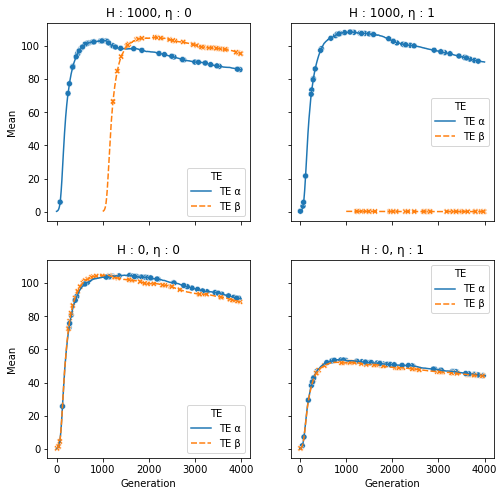

In [5]:
# Create a multipanel figure
# sns.set_context("talk")
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 8))
(ax1, ax2), (ax3, ax4) = axs
TECNplot(result_E0_G1000, ax1)
ax1.title.set_text("H : 1000, η : 0")
TECNplot(result_E1_G1000, ax2)
ax2.title.set_text("H : 1000, η : 1")
TECNplot(result_E0_G0, ax3)
ax3.title.set_text("H : 0, η : 0")
TECNplot(result_E1_G0, ax4)
ax4.title.set_text("H : 0, η : 1")

Text(0, 0.5, 'H')

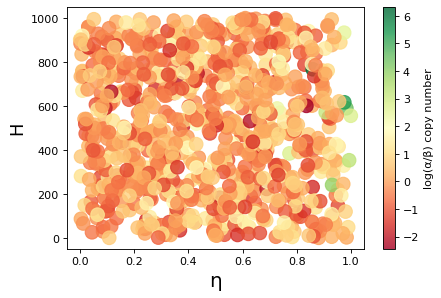

In [6]:
cmap = sns.color_palette("RdYlGn", as_cmap=True)

f, ax = plt.subplots(figsize=(6, 4), dpi=80)
points = ax.scatter(
    result_all["ETA"],
    result_all["HGTGen"],
    c=result_all["log(α/β) copy number"],
    s=150,
    cmap=cmap,
    alpha=0.8,
)
f.colorbar(points).set_label("log(α/β) copy number")
ax.set_xlabel("η", fontsize=18)
ax.set_ylabel("H", fontsize=16)

/tmp/ipykernel_13609/3232838125.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(points, ax=ax_main).set_label("log(Max α/β)")


Text(0, 0.5, 'H')

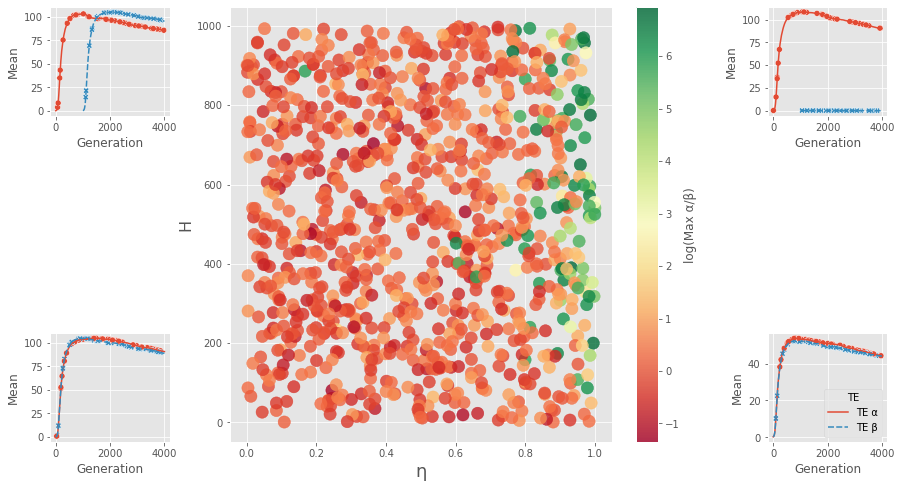

In [7]:
# A gridspec based approach for plotting
style.use("ggplot")

fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(3, 5)
gs.update(wspace=0.5, hspace=0.5)
ax_main = plt.subplot(gs[0:3, 1:4])
ax_E0_G0 = plt.subplot(gs[2, 0])
ax_E1_G0 = plt.subplot(gs[2, 4])
ax_E0_G1000 = plt.subplot(gs[0, 0])
ax_E1_G1000 = plt.subplot(gs[0, 4])

# Plot the corners
TECNplot(result_E0_G1000, ax_E0_G1000, legend=False)
ax1.title.set_text("H : 1000, η : 0")
TECNplot(result_E1_G1000, ax_E1_G1000, legend=False)
ax2.title.set_text("H : 1000, η : 1")
TECNplot(result_E0_G0, ax_E0_G0, legend=False)
ax3.title.set_text("H : 0, η : 0")
TECNplot(result_E1_G0, ax_E1_G0, legend=True)
ax4.title.set_text("H : 0, η : 1")

# Plot the main figure
points = ax_main.scatter(
    result_all["ETA"],
    result_all["HGTGen"],
    c=result_all["Max α/β"],
    s=150,
    cmap=cmap,
    alpha=0.8,
)
fig.colorbar(points, ax=ax_main).set_label("log(Max α/β)")
ax_main.set_xlabel("η", fontsize=18)
ax_main.set_ylabel("H", fontsize=16)

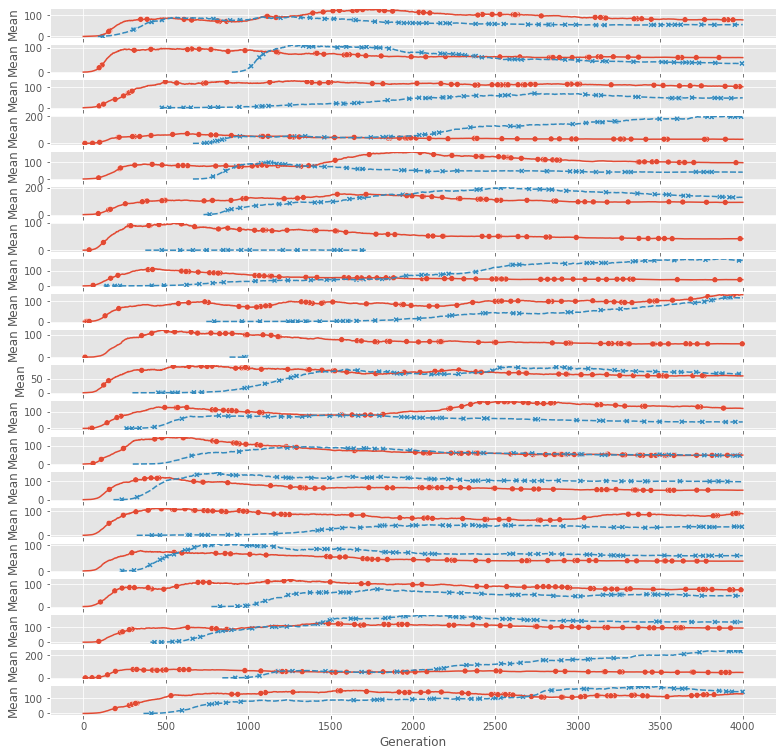

In [10]:
# Diagnostics
# Functions for mk1 eyeball sensors to detect any strange objects
def createMeanPanels(dataFrame):
    fig, axs = plt.subplots(len(dataFrame), 1, sharex=True, figsize=(13, 13))
    # f, ax = plt.subplots()
    for i in range(len(dataFrame)):
        TECNplot(pd.DataFrame(dataFrame.iloc[i]).T, axs[i], legend=False)


subsetDF = result_all.loc[np.random.choice(result_all.index, 20, replace=False)]
createMeanPanels(subsetDF)

In [16]:
0.001 / 0.05

0.02

In [12]:
result_all["log(α/β) copy number"].replace([np.inf, -np.inf], 5, inplace=True)

/home/siddharth/mambaforge/lib/python3.9/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [ ]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)